In [1]:
import os

# 获取当前工作目录
current_dir = os.getcwd()
print("当前工作目录：", current_dir)
 
# 切换到上一层目录
parent_dir = os.path.dirname(current_dir)
os.chdir(parent_dir)
print("切换后的目录：", parent_dir)

当前工作目录： c:\Users\zhaoxs3\Documents\GitHub\NEMESIS\unit_test
切换后的目录： c:\Users\zhaoxs3\Documents\GitHub\NEMESIS


In [2]:
import QuantLib as ql
import pandas as pd

from devlib.market.curves.overnight_index_curves import Sofr
from devlib.products.rates.irs.general_irs import *

In [3]:
from nemesis.products.rates import *

####################################################################
#  NEMESIS ALPHA Version 0.1.0 - This build: 24 Jan 2025 at 10:42 #
####################################################################



In [4]:
today = ql.Date(27, 11, 2024)
ql.Settings.instance().evaluationDate = today

mkt_file_path = './unit_test/data/sofr_curve_data_20241127.xlsx'
swap_mkt_data = pd.read_excel(mkt_file_path, sheet_name='swap')
fixing_data = pd.read_excel(mkt_file_path, sheet_name='fixing')

index_curve = Sofr(today, swap_mkt_data=swap_mkt_data, fixing_data=fixing_data)
discount_curve = Sofr(today, swap_mkt_data=swap_mkt_data, fixing_data=fixing_data)

In [5]:
value_dt = Date(27,11,2024)
curve = QLCurve(value_dt, discount_curve, dc_type=DayCountTypes.ACT_360, interp_type=InterpTypes.LINEAR_ZERO_RATES)

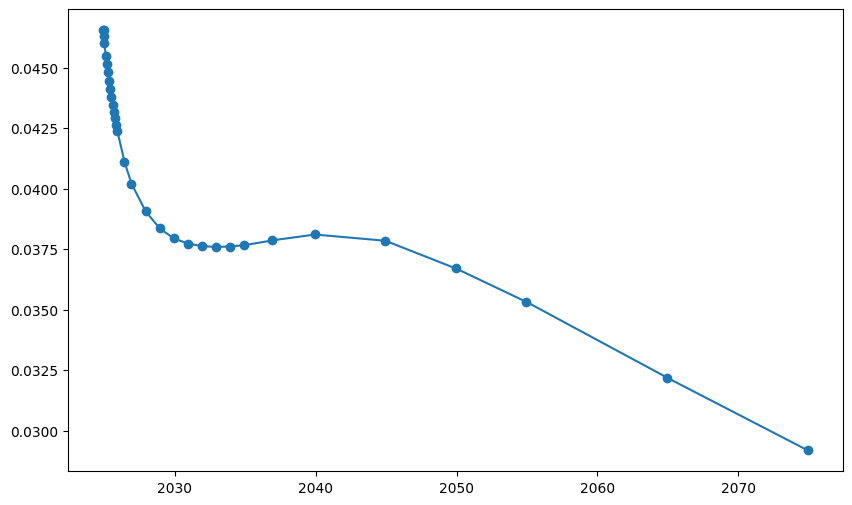

In [6]:
curve.print_figure(curve.pillar_dts[1:])

In [7]:
fixed_type = SwapTypes.PAY
fixed_freq = FrequencyTypes.ANNUAL
fixed_dc_type = DayCountTypes.ACT_360

swap = OIS(
    effective_dt=Date(19,7,2024),
    term_dt_or_tenor=Date(18,7,2027),
    fixed_leg_type=fixed_type,
    fixed_cpn=0.05558,
    fixed_freq_type=fixed_freq,
    fixed_dc_type=fixed_dc_type,
    notional=32061781.09,
    payment_lag=0,
    float_multiplier=1.0,
    float_spread=0,
    float_compounding_type='',
    float_freq_type=FrequencyTypes.ANNUAL,
    float_dc_type=DayCountTypes.ACT_360,
    cal_type=CalendarTypes.UNITED_STATES,
    bd_type=BusDayAdjustTypes.MODIFIED_FOLLOWING,
    dg_type=DateGenRuleTypes.BACKWARD,
    reset_freq='None',
    fixing_days=2,
    end_of_month= False,
    is_ois_leg=True,
)

In [8]:
swap.value(value_dt=value_dt, ois_curve=curve)

np.float64(-1305277.5169062256)